## Extracao de dados do Satélite Sentinel-2
Esse notebook vai servir pra gerar os Geotiff extraídos do Sentinel2 que futuramente vai formar o nosso dataset. 

In [1]:
!pip install numpy xarray matplotlib rioxarray rasterio stackstac pystac-client planetary-computer odc-stac

  Using cached xarray-2025.6.1-py3-none-any.whl.metadata (12 kB)
  Using cached rioxarray-0.19.0-py3-none-any.whl.metadata (5.5 kB)
  Using cached stackstac-0.5.1-py3-none-any.whl.metadata (8.1 kB)
  Using cached pystac_client-0.8.6-py3-none-any.whl.metadata (3.0 kB)
  Using cached planetary_computer-1.0.0-py3-none-any.whl.metadata (7.4 kB)
  Using cached odc_stac-0.4.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached certifi-2025.6.15-py3-none-any.whl.metadata (2.4 kB)
  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1.2-py2.py3-none-any.whl.metadata (6.5 kB)
  Using cached dask-2025.5.1-py3-none-any.whl.metadata (3.8 kB)
  Usi

In [ ]:
# Warnings
import warnings
warnings.filterwarnings('ignore')

# Importando  bibliotecas
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu

import stackstac
import pystac_client
import planetary_computer
from odc.stac import stac_load

# Carregando os dados para análise

 Primeiro, definimos nossa área de interesse usando coordenadas de latitude e longitude.
 Foi escolhido diferentes recortes do Rio de Janeiro, o mesmo processo a seguir foi repetido individualmente para cada um dos recortes.


In [ ]:
# Recorte 1
lower_left  = (-23.05, -43.50)  # latitude, longitude
upper_right = (-22.80, -43.15)

In [ ]:
# Recorte 2 – Zona Norte / Maracanã a Del Castilho
#lower_left  = (-22.96, -43.35)
#upper_right = (-22.80, -43.10)

# Recorte 3 – Barra da Tijuca e Recreio
#lower_left  = (-23.03, -43.42)
#upper_right = (-22.85, -43.17)

#Recorte 4 – Centro + Zona Portuária
#lower_left  = (-22.94, -43.25)
#upper_right = (-22.80, -43.00)

# Recorte 5 – Ilha do Governador / Fundão / Aeroporto Galeão
#lower_left  = (-22.90, -43.30)
#upper_right = (-22.75, -43.05)

# Recorte 6 – Jacarepaguá e Taquara
#lower_left  = (-23.00, -43.45)
#upper_right = (-22.85, -43.20)

# Recorte 7 – Zona Oeste (Campo Grande, Bangu)
#lower_left  = (-23.03, -43.60)
#upper_right = (-22.85, -43.35)

# Recorte 8 – Região de Niterói
lower_left  = (-22.95, -43.15)
upper_right = (-22.80, -42.90)

#Recorte 9 – Guaratiba e Itaguai
#lower_left  = (-23.10, -43.80)
#upper_right = (-22.95, -43.55)

In [ ]:
# Calculando os limites para realizar uma busca de dados arquivados
# bounds = (lon_min, lat_min, lon_max, lat_max)

bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [ ]:
# Definindo a janela de tempo

time_window = "2024-01-01/2024-03-03"

 Usando o 'pystac_client', podemos buscar no endpoint STAC do Planetary Computer por itens que correspondem aos nossos parâmetros de consulta.
  Utilizaremos um período de 3 meses como um conjunto de dados representativo para a região.
 A consulta busca por cenas de "nuvens baixas" com cobertura de nuvens < 10%. 
 O resultado é o número de cenas que correspondem aos nossos critérios de busca e que tocam nossa área de interesse.
 Algumas dessas cenas podem ser parciais ou conter nuvens.



In [213]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 10}},
)

In [ ]:
items = list(search.get_items())
print('Numeros de cenas com essas especificacoes:',len(items))

This is the number of scenes that touch our region: 2


 Em seguida, vamos carregar os dados em um DataArray do [xarray](https://xarray.pydata.org/en/stable/) usando o [stackstac](https://stackstac.readthedocs.io/).
 Vamos manter apenas as bandas espectrais comumente usadas (Vermelho, Verde, Azul, NIR, SWIR).
 Também há várias outras <b>configurações importantes para os dados</b>: Alteramos a projeção para epsg=4326, que é o padrão de latitude-longitude em graus.
 Especificamos a resolução espacial de cada pixel como sendo de 10 metros.


In [215]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [ ]:
# Defininndo a resolução dos pixels para o produto final
# Definindo a escala de acordo com o nosso CRS selecionado, então usaremos graus

resolution = 10  # metros por pixel
scale = resolution / 111320.0 # graus por pixel para crs=4326

### Resumo das Bandas Sentinel-2
A seguinte lista de bandas comuns pode ser carregada pelo comando STAC do Open Data Cube (ODC).<br><br>
B01 = Aerossol Costeiro = 60m <br>
B02 = Azul = 10m <br>
B03 = Verde = 10m <br>
B04 = Vermelho = 10m <br>
B05 = Borda Vermelha (704 nm) = 20m <br>
B06 = Borda Vermelha (740 nm) = 20m <br>
B07 = Borda Vermelha (780 nm) = 20m <br>
B08 = NIR (833 nm) = 10m <br>
B8A = NIR (estreita 864 nm) = 20m <br>
B11 = SWIR (1.6 um) = 20m <br>
B12 = SWIR (2.2 um) = 20m


In [ ]:
data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Graus por pixel
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

### Visualizando imagens RGB (cores reais) da série temporal
 


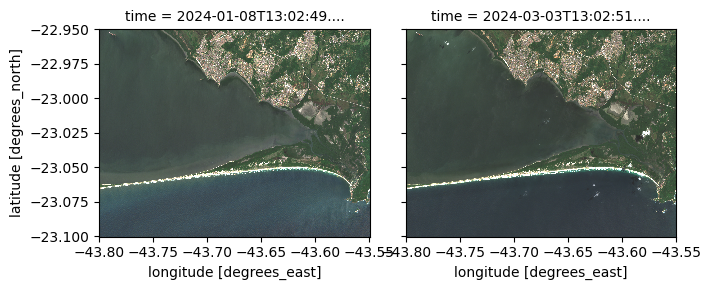

In [ ]:
# Plot 
plot_data = data[["B04","B03","B02"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=500, vmax=3500)
plt.show()

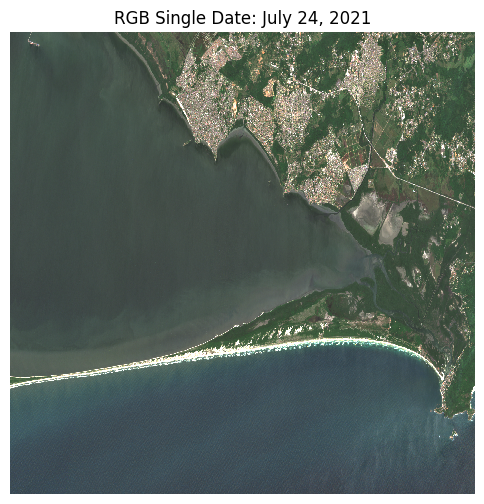

In [220]:
# Plot an RGB image for a single date
fig, ax = plt.subplots(figsize=(6,6))
plot_data.isel(time=0).plot.imshow(robust=True, ax=ax, vmin=500, vmax=3500)
ax.set_title("RGB Single Date: July 24, 2021")
ax.axis('off')
plt.show()

### Mediana 

calcular a mediana - (http://xarray.pydata.org/en/stable/generated/xarray.DataArray.median.html) . Sob a suposição de que as nuvens não são comuns (<10% por cena) e estão em locais aleatórios, o composto não contem (muitas) nuvens,obtemos o valor da mediana do pixel nesse ponto ao longo de várias imagens.


In [221]:
median = data.median(dim="time").compute()

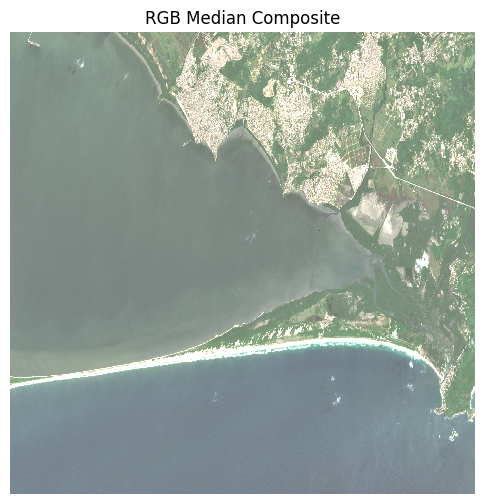

In [ ]:
# Plot

fig, ax = plt.subplots(figsize=(6,6))
median[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Median Composite")
ax.axis('off')
plt.show()

O <b>Índice de Vegetação por Diferença Normalizada (NDVI)</b> é utilizado para medir a "verdor" da vegetação e tem uma faixa de 0.0 a 1.0. Valores baixos (0.0 a 0.25) indicam a falta de vegetação (solo nu, áreas urbanas, água), valores intermediários (0.25 a 0.6) indicam campos ou terras agrícolas em estado de crescimento, e valores altos (0.6 a 1.0) indicam vegetação densa, como árvores ou terras agrícolas no pico de vegetação. Tais informações podem ser relevantes para modelar o aquecimento urbano, pois a proximidade de vegetação ou "áreas verdes" pode mitigar o aquecimento urbano. A equação utiliza duas bandas espectrais onde: <b>NDVI = (NIR-Vermelho) / (NIR+Vermelho).


In [ ]:
# Calculando o NDVI (Índice de Vegetação por Diferença Normalizada)
ndvi_median = (median.B08-median.B04)/(median.B08+median.B04)

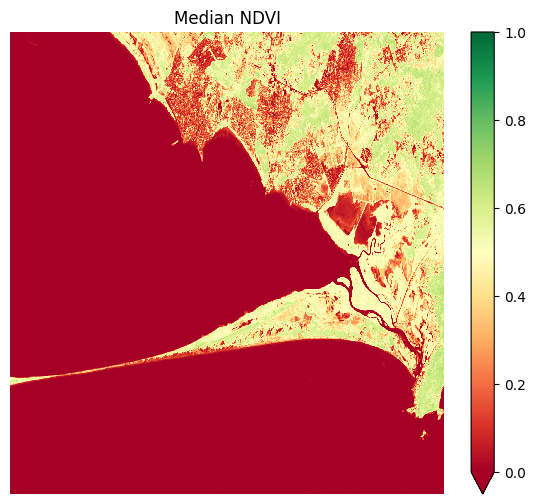

In [226]:
fig, ax = plt.subplots(figsize=(7,6))
ndvi_median.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Median NDVI")
plt.axis('off')
plt.show()

O <b>Índice de Vegetação por Diferença Normalizada (NDVI)</b> é utilizado para medir a "verdor" da vegetação e tem uma faixa de 0.0 a 1.0. Valores baixos (0.0 a 0.25) indicam a falta de vegetação (solo nu, áreas urbanas, água), valores intermediários (0.25 a 0.6) indicam campos ou terras agrícolas em estado de crescimento, e valores altos (0.6 a 1.0) indicam vegetação densa, como árvores ou terras agrícolas no pico de vegetação. Tais informações podem ser relevantes para modelar o aquecimento urbano, pois a proximidade de vegetação ou "áreas verdes" pode mitigar o aquecimento urbano. A equação utiliza duas bandas espectrais onde: <b>NDVI = (NIR-Vermelho) / (NIR+Vermelho).


In [ ]:
# Calculando o NDBI (Índice de Construção por Diferença Normalizada)
ndbi_median = (median.B11-median.B08)/(median.B11+median.B08)

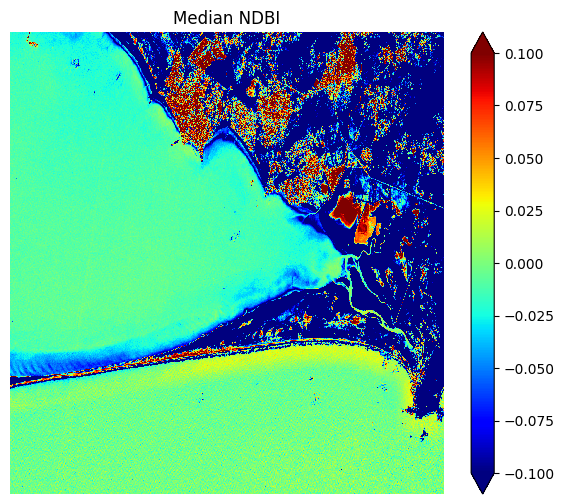

In [228]:
fig, ax = plt.subplots(figsize=(7,6))
ndbi_median.plot.imshow(vmin=-0.1, vmax=0.1, cmap="jet")
plt.title("Median NDBI")
plt.axis('off')
plt.show()

O <b>Índice de Diferença Normalizada da Água (NDWI)</b> é um índice baseado em razão que utiliza as bandas Verde e Infravermelho Próximo (NIR) para destacar áreas com água na superfície. A escala abaixo está configurada para destacar áreas de água (acima de zero) em AZUL e áreas sem água (abaixo de zero) em VERMELHO. Tais informações podem ser relevantes para modelar o aquecimento urbano, pois a proximidade da água pode mitigar o aquecimento urbano. A equação utiliza duas bandas espectrais onde: <b>NDWI = (VERDE-NIR) / (VERDE+NIR).


In [ ]:
# Calculando o NDWI (Índice de Água por Diferença Normalizada) para o mosaico mediano
ndwi_median = (median.B03-median.B08)/(median.B03+median.B08)

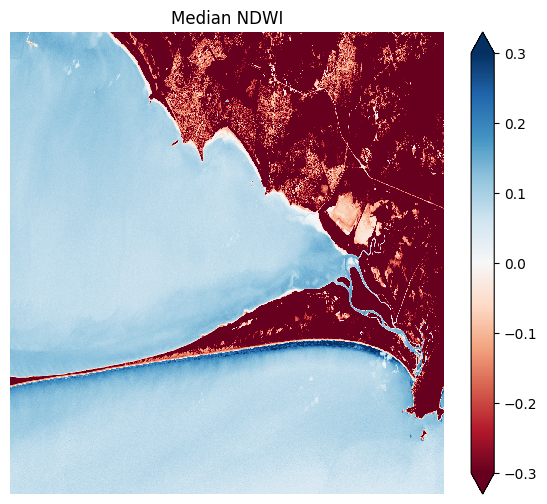

In [230]:
fig, ax = plt.subplots(figsize=(7,6))
ndwi_median.plot.imshow(vmin=-0.3, vmax=0.3, cmap="RdBu")
plt.title("Median NDWI")
plt.axis('off')
plt.show()

### Salvando os dados de saída em um arquivo GeoTIFF
Selecionamos uma única data  para criar um produto de saída em GeoTIFF. Essa data é a mesma em que os dados de temperatura do solo foram coletados. 

In [231]:
filename = "recorte9.tiff"

In [ ]:
# Vamos selecionar um único dia da série temporal (time=7)

data_slice = data.isel(time=1)

In [ ]:
# Calculando as dimensões do mosaico
height = median.dims["latitude"]
width = median.dims["longitude"]


In [ ]:
# Definindo o sistema de referência de coordenadas (CRS) e a transformação
# A transformação é definida a partir dos limites do recorte e das dimensões do mosaico
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
data_slice.rio.write_crs("epsg:4326", inplace=True)
data_slice.rio.write_transform(transform=gt, inplace=True);

In [ ]:
# Criando o arquivo GeoTIFF com as bandas selecionadas
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=8,compress='lzw',dtype='float64') as dst:
    dst.write(median.B01,1)
    dst.write(median.B04,2)
    dst.write(median.B06,3)
    dst.write(median.B08,4)
    dst.write(ndvi_median,5)
    dst.write(ndbi_median,6)
    dst.write(ndwi_median,7)
    dst.write(median.B03,8)
    dst.close()

In [ ]:
# Vendo os aequivos salvos
!ls *.tiff

'ls' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.
